### AutoEncoder & Dimension Reduction

선형 오토인코더와 PCA는 어떤 공통점이 있을까?

In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers, models, optimizers

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
def LinearAutoEncoder(
        y, 
        dimension, 
        learning_rate = 1e-4, 
        regularization = 1e-5, 
        epochs=10 
):
    
    input_layer = Input(shape=(y.shape[1],))
    encoder = Dense(
        dimension, 
        activation = 'linear',
        kernel_regularizer = regularizers.l2(regularization)
    )(input_layer)
    decoder = Dense(
        y.shape[1], 
        activation = 'linear',
        kernel_regularizer=regularizers.l2(regularization)
    )(encoder)
    
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(
        optimizer = optimizers.Adam(learning_rate = learning_rate), 
        loss = 'mean_squared_error'
    )
    
    autoencoder.fit(
        y, y, 
        epochs = epochs, 
        batch_size = 4, 
        shuffle = True,
        verbose = 0
    )
    
    return autoencoder

#### Data Import

yield curve를 sample로 활용한다. 미국의 국채 이자율을 사용한다

In [3]:
yield_curve = pd.read_csv('../Data/yield_curve.csv', sep = ',', index_col = 0)
yield_curve.index = pd.to_datetime(yield_curve.index)
n_obs = len(yield_curve)

In [4]:
yield_curve.drop('Index', axis = 1, inplace = True)
yield_curve.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
Date,,,,,,,,,,,,,,
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


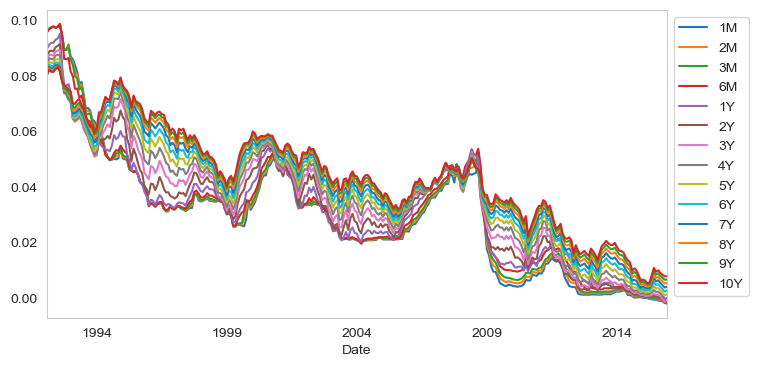

In [5]:
import matplotlib.pyplot as plt

yield_curve.plot(figsize = (8,4))
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.grid(False)
plt.show()

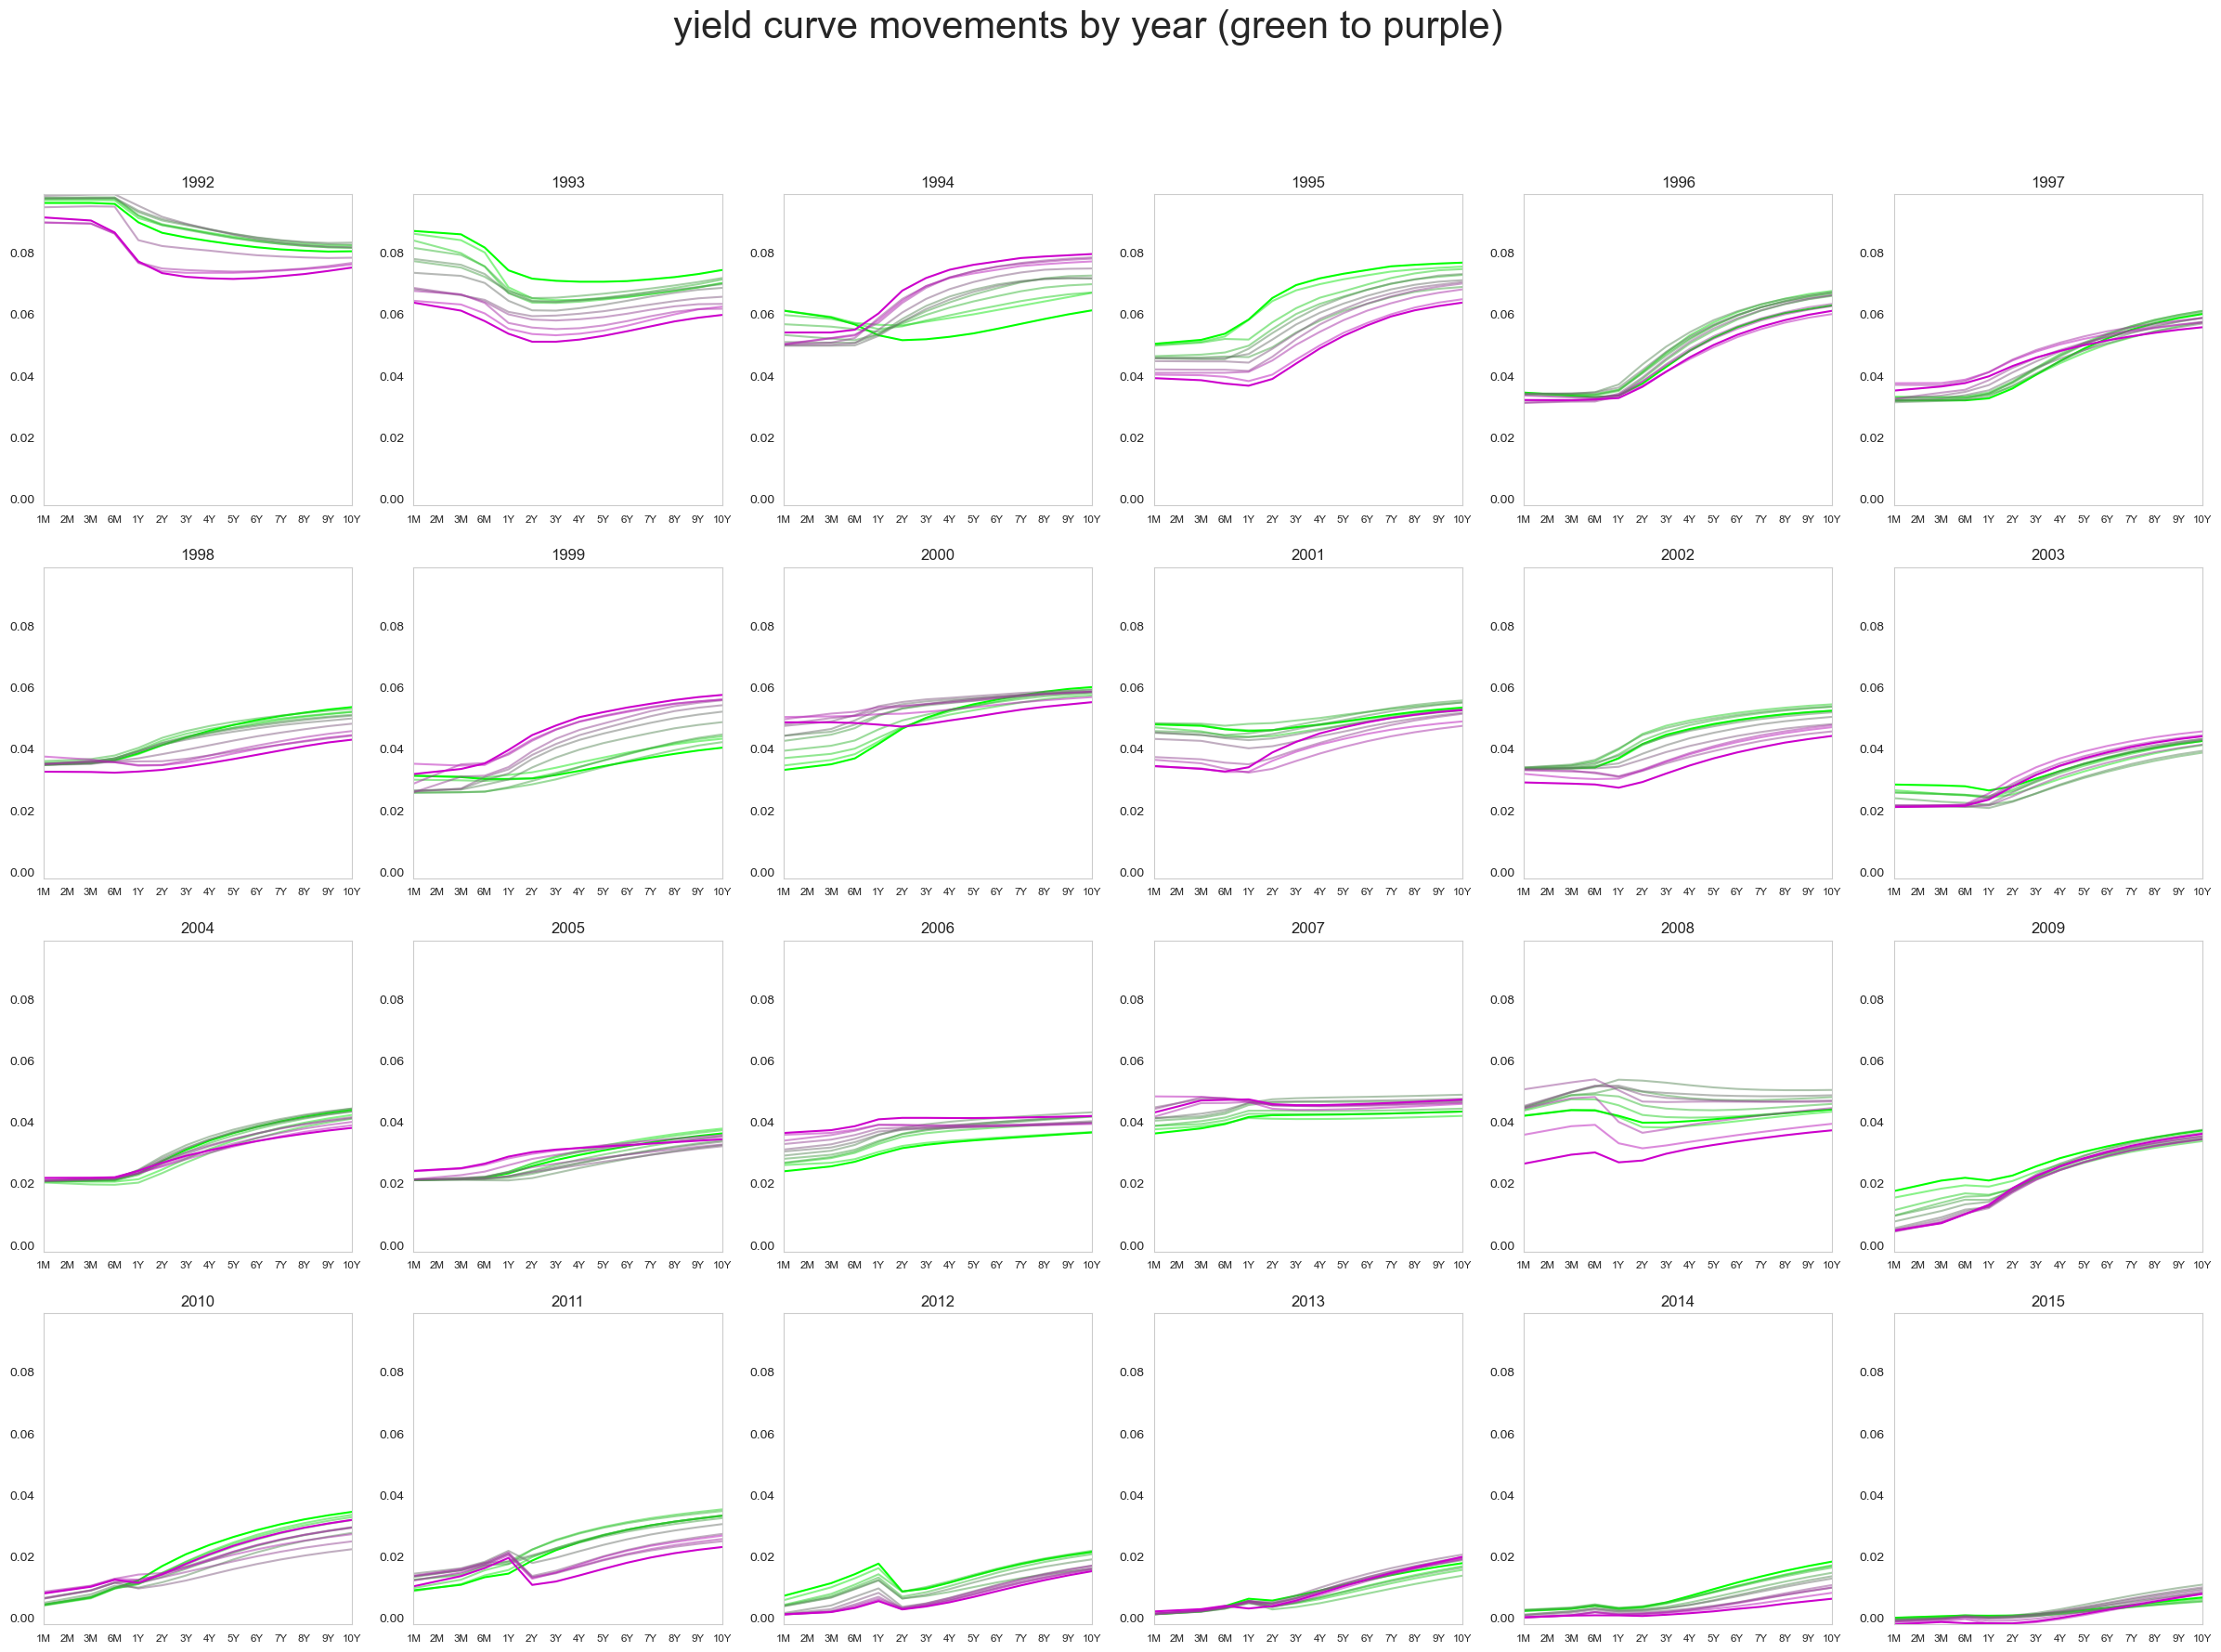

In [6]:
cols = 6
num_years = yield_curve.index.max().year - yield_curve.index.min().year
rows = int(np.ceil(num_years/cols))

plt.figure(figsize = (30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize = 30)

colnum = 0
rownum = 0
for year in range(yield_curve.index.min().year, yield_curve.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(yield_curve.columns)-1)
    plt.ylim(np.min(yield_curve.values), np.max(yield_curve.values))
    plt.grid(False)
    plt.xticks(range(len(yield_curve.columns)), yield_curve.columns, size='small')
    
    year_curves = yield_curve.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.5
    
    for y, colour in zip(year_curves, gradient):
        plt.plot(y, c=colour)

    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

#### Principal Components Analysis

In [7]:
pca_model = PCA(n_components = 3, copy = True, whiten = False)
pca_model.fit(yield_curve)

PCA(n_components=3)

In [8]:
df_pca = pd.DataFrame(
    pca_model.transform(yield_curve),
    index = yield_curve.index
)

In [9]:
df_pca_recon = pd.DataFrame(
    pca_model.inverse_transform(df_pca),
    index = yield_curve.index,
    columns = yield_curve.columns
)

In [10]:
df_pca.head()

,0,1,2
Date,,,
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


In [11]:
df_pca_recon.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
Date,,,,,,,,,,,,,,
1992-02-29,0.096439,0.096361,0.096284,0.094598,0.089881,0.086977,0.085120,0.083574,0.082320,0.081445,0.080926,0.080605,0.080459,0.080480
1992-03-31,0.097142,0.097178,0.097214,0.095800,0.091746,0.089400,0.087671,0.086120,0.084802,0.083840,0.083228,0.082809,0.082568,0.082500
1992-04-30,0.097630,0.097707,0.097783,0.096413,0.092320,0.089719,0.087752,0.085996,0.084514,0.083421,0.082706,0.082211,0.081916,0.081814
1992-05-31,0.098070,0.098096,0.098122,0.096631,0.092286,0.089533,0.087544,0.085802,0.084348,0.083287,0.082605,0.082142,0.081877,0.081801
1992-06-30,0.097455,0.097632,0.097808,0.096675,0.093123,0.090917,0.089032,0.087263,0.085729,0.084569,0.083783,0.083216,0.082851,0.082685


Plot the reconstruction error per variable for PCA

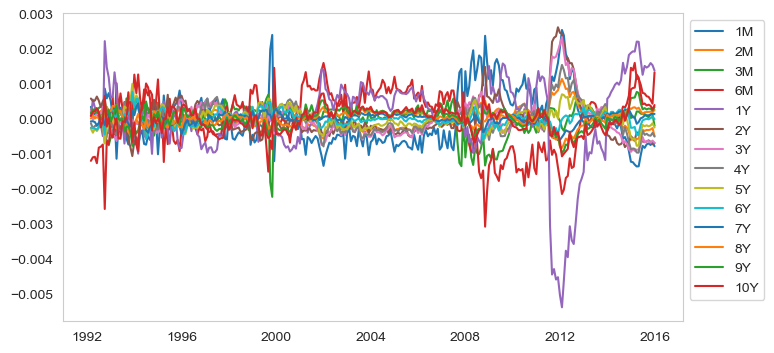

In [12]:
plt.figure(figsize = (8,4))
plt.plot(yield_curve.index, df_pca_recon - yield_curve.values)
plt.legend(yield_curve.columns, loc = 'upper left', bbox_to_anchor = (1, 1))
plt.grid(False)
plt.show()

Evaluate the amount of variance explained by each component

In [13]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.53%
PC 2:	 4.07%
PC 3:	 0.33%


주성분 1이 95.53%의 변동을 설명한다

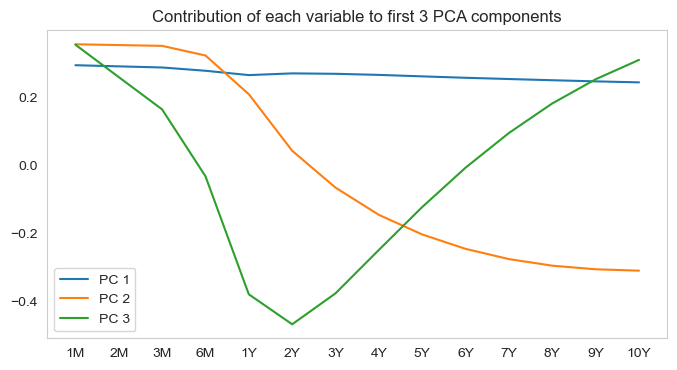

In [14]:
fig = plt.figure(figsize = (8,4))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.n_components))

plt.plot(np.transpose(pca_model.components_[0]), label = 'PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label = 'PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label = 'PC 3')
plt.xticks(range(len(yield_curve.columns)), yield_curve.columns)
plt.grid(False)

plt.legend();

주성분 1은 height, 주성분 2는 slope 형태를 띄며, 주성분 3은 V자 형태를 띄는 것을 알 수 있다

#### Linear Autoencoders

선형 오토인코더로 차원 축소를 진행해 보자, epochs는 1000, dimension은 3으로 지정한다

In [15]:
autoencoder = LinearAutoEncoder(
    yield_curve.values, 
    dimension = 3, 
    regularization = 0, 
    epochs = 1000
)

2023-12-24 02:31:52.764265: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


decoder weight matrix로부터 singular vector를 추출한다

In [16]:
(w1, b1, w2, b2) = autoencoder.get_weights()

In [17]:
(ae_decoder_lsv, _, _) = np.linalg.svd(w2.T, full_matrices = False)

In [18]:
mu = np.mean(yield_curve.values, axis=0)
ae_lsv_projections = np.array(yield_curve.values-mu) @ ae_decoder_lsv

차원 축소된 matrix를 생성한다

In [19]:
df_ae = pd.DataFrame(ae_lsv_projections, index = yield_curve.index)

In [20]:
df_ae

,0,1,2
Date,,,
1992-02-29,0.093731,-0.160076,-0.050751
1992-03-31,0.098822,-0.163528,-0.055080
1992-04-30,0.098952,-0.164400,-0.053466
1992-05-31,0.098493,-0.165004,-0.053162
1992-06-30,0.101443,-0.165244,-0.055670
...,...,...,...
2015-08-31,-0.065663,0.087486,0.062122
2015-09-30,-0.066822,0.088297,0.064110
2015-10-31,-0.068540,0.089265,0.065666


#### Compare the transformed sample covariances

sample covariance matrix C를 선언하자

In [21]:
C = np.dot((yield_curve - mu).T, yield_curve - mu)

total variance는 covariance matrix의 diagonal elements 합으로 이뤄진다. 

In [22]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

total variance: 1.7086096174655052


Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

In [23]:
lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

<Axes: >

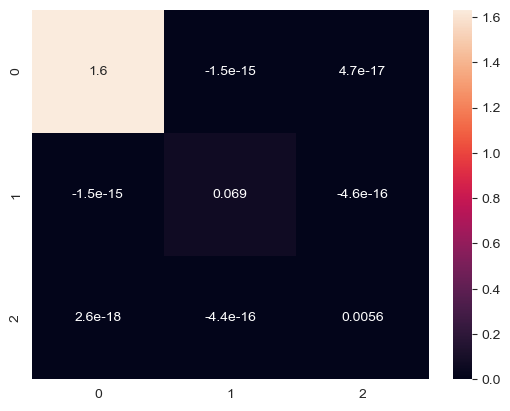

In [24]:
sns.heatmap(lambda_from_pca, annot = True)

covariance matrix를 보면 첫 번째 주성분이 대부분의 변동을 설명하는 것을 알 수 있다

In [25]:
print(100 * np.diag(lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(lambda_from_pca)) / total_variance))

[95.53366571  4.0667419   0.32890998]
99.9293% of total variance explained


이제 decoder의 weight를 사용하여 공분산 행렬의 변환을 수행한다. 행렬 $\Lambda$는 더 이상 대각행렬이 아니다

In [26]:
lambda_from_decoder_weights = w2 @ C @ w2.T

<Axes: >

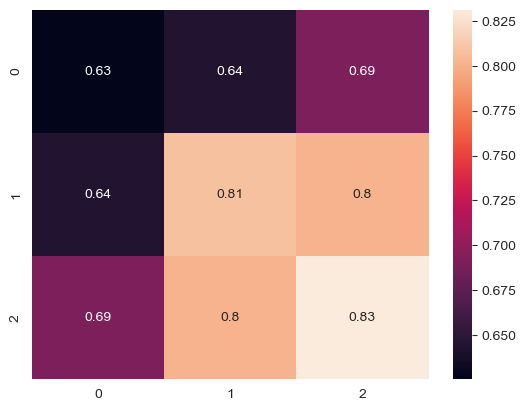

In [27]:
sns.heatmap(lambda_from_decoder_weights, annot = True)

마지막으로 decoder weight의 left singular matrix를 사용하여 공분산 행렬의 변환을 수행한다. 공분산 행렬은 대각화되지 않지만 정렬된 각 대각선 요소가 설명하는 분산의 비율은 PCA에서 얻은 값과 유사하다는 것을 알 수 있다

In [28]:
lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv

<Axes: >

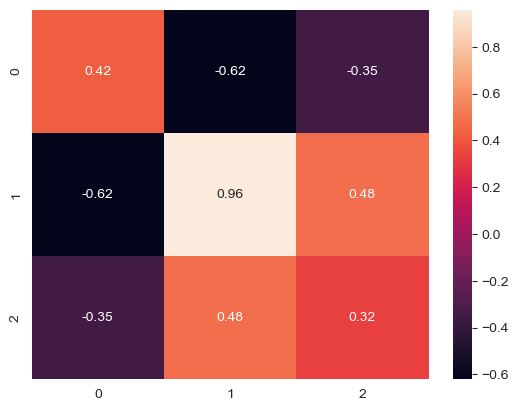

In [29]:
sns.heatmap(lambda_from_decoder_lsv, annot = True)

Auto encoder 모형에서 추정된 설명된 분산 비율을 보자

In [30]:
print(100 * np.diag(lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(lambda_from_decoder_lsv)) / total_variance))

[24.85620417 56.10772956 18.94702821]
99.911% of total variance explained


#### Recontruct Data

Auto Encoder의 decoding network를 통해 data를 generating할 수 있다. 우선, 학습된 모형으로부터 generating해 보자

In [31]:
df_ae_recon = autoencoder.predict(yield_curve.values)

9/9 [==============================] - 0s 479us/step


In [32]:
df_ae_recon = pd.DataFrame(
    df_ae_recon,
    index = yield_curve.index,
    columns = yield_curve.columns
)

In [33]:
df_ae_recon.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
Date,,,,,,,,,,,,,,
1992-02-29,0.097101,0.097126,0.096984,0.094868,0.089935,0.086606,0.085011,0.083613,0.082434,0.081491,0.080957,0.080709,0.080552,0.080689
1992-03-31,0.097840,0.097980,0.098085,0.096221,0.091602,0.089052,0.087682,0.086235,0.084962,0.083865,0.083219,0.082854,0.082487,0.082718
1992-04-30,0.098380,0.098540,0.098687,0.096822,0.092036,0.089265,0.087701,0.086075,0.084664,0.083451,0.082723,0.082299,0.081876,0.082115
1992-05-31,0.098922,0.099023,0.099055,0.097057,0.092125,0.089080,0.087444,0.085850,0.084481,0.083331,0.082645,0.082264,0.081922,0.082113
1992-06-30,0.098185,0.098438,0.098777,0.097125,0.092613,0.090426,0.089042,0.087396,0.085932,0.084619,0.083821,0.083322,0.082752,0.083068


그러면 각 변수의 재구성된 값을 모든 점에 대한 원래 값과 비교하여 그림을 그릴 수 있다. 차원 축소에 의해 도입된 차이는 대각성분으로부터의 편차로 나타난다

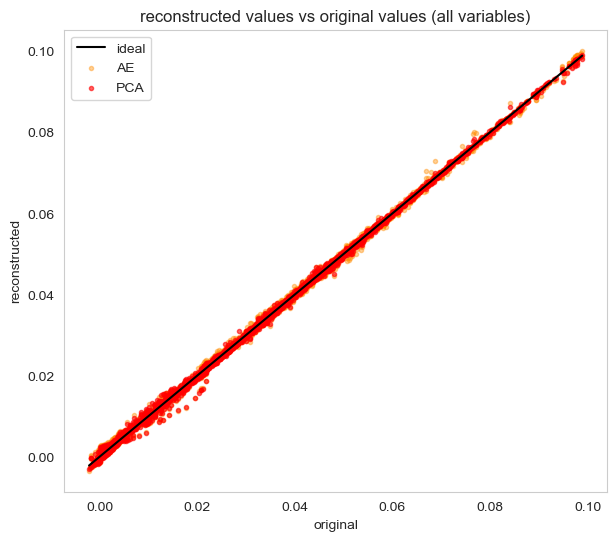

In [34]:
plt.figure(figsize = (7, 6))
plt.title('reconstructed values vs original values (all variables)')
xy = np.linspace(yield_curve.values.min(), yield_curve.values.max(), 2)

plt.plot(xy, xy, c = 'black') # y = x
plt.scatter(yield_curve.values, df_ae_recon, marker = '.', c = 'darkorange', alpha = 0.4) 
plt.scatter(yield_curve.values, df_pca_recon, marker = '.', c = 'red', alpha = 0.6) 
plt.grid(False)

plt.xlabel('original')
plt.ylabel('reconstructed')
plt.legend(['ideal', 'AE', 'PCA']);

**Visualize the data projected onto the principal component**

먼저 PCA에서 얻은 주성분에 대한 데이터를 보여주고 decode weight matrix의 left singular vector를 사용하여 데이터를 보여준다

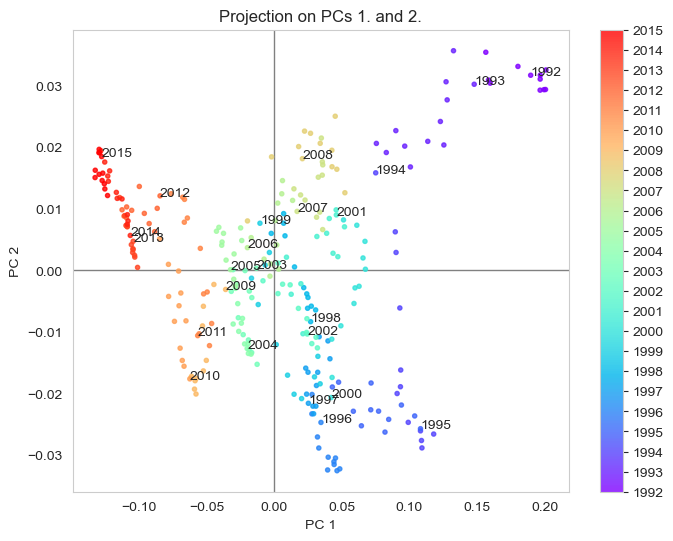

In [35]:
pc1 = 0
pc2 = 1

merged_years = 1

fig = plt.figure(figsize = (8,6))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC ' + str(pc1+1))
plt.ylabel('PC ' + str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
plt.grid(False)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], 
                 c = [d.year for d in df_pca.index], cmap = 'rainbow',
                 marker = '.', alpha = 0.8)
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]));

decoder weight matrix의 left singular vector를 사용하여 plotting한다

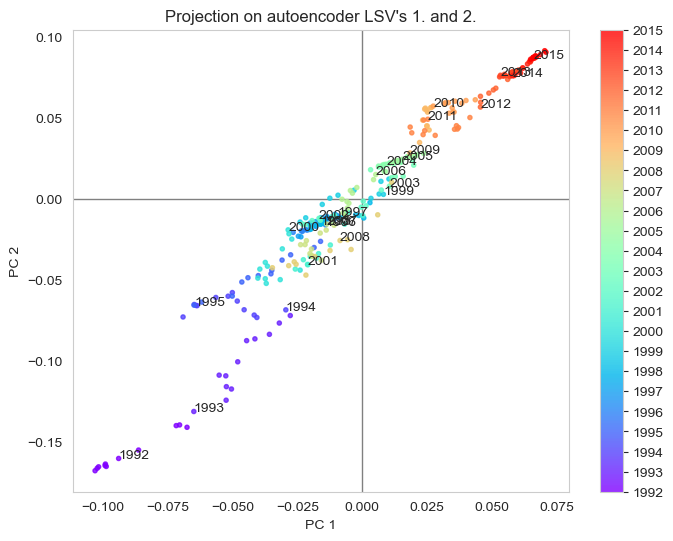

In [36]:
pc1 = 0
pc2 = 1

merged_years = 1
fig = plt.figure(figsize = (8, 6))
plt.title('Projection on autoencoder LSV\'s {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC ' + str(pc1+1))
plt.ylabel('PC ' + str(pc2+1))
plt.axhline(y = 0, c = "grey", linewidth = 1.0, zorder = 0)
plt.axvline(x = 0, c = "grey", linewidth = 1.0, zorder = 0)
plt.grid(False)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], 
                 c=[d.year for d in df_ae.index], cmap = 'rainbow', 
                 marker = '.', alpha = 0.8)
cb = plt.colorbar(sc)
cb.set_ticks(ticks = np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), 
                 xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]))

generating error를 확인해 보자

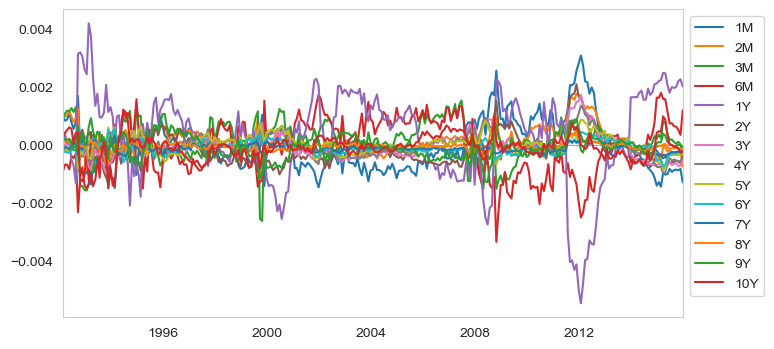

In [37]:
plt.figure(figsize = (8, 4))
plt.plot(yield_curve.index, pd.DataFrame(df_ae_recon - yield_curve))
plt.legend(yield_curve.columns, loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xlim(yield_curve.index.min(), yield_curve.index.max())
plt.grid(False)
plt.axhline(y = 0, c = "grey", linewidth = 0.5, zorder = 0)

#### Deep Autoencoder

Deep Autoencoder에 $tanh$ 활성화 함수가 있는 두 개의 encoder와 두 개의 decoder layer를 가정한다

첫 번째 layer는 `2*dimension` 특징의 집합으로 입력을 줄이고, 두 번째 layer는 이를 `dimension`으로 반으로 줄인다

두 decoder 층은 이 과정을 반대로 하여 각 층의 단위 수를 먼저 원래 변수 수의 절반으로 증가시킨 다음 다시 입력 공간으로 들어간다

In [38]:
def DeepAutoEncoder(
        y, 
        dimension,
        learning_rate = 1e-4, 
        regularization = 5e-4, 
        epochs = 10
):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(
        np.int64(2*dimension), 
        activation = 'tanh',
        kernel_regularizer = regularizers.l2(regularization)
    )(input)
    encoded2 = Dense(
        dimension, 
        activation = 'tanh',
        kernel_regularizer = regularizers.l2(regularization)
    )(encoded1)
    decoded1 = Dense(
        np.int64(y.shape[1]/2), 
        activation = 'tanh',
        kernel_regularizer = regularizers.l2(regularization)
    )(encoded2)
    decoded2 = Dense(
        y.shape[1], 
        activation = 'tanh',
        kernel_regularizer = regularizers.l2(regularization)
    )(decoded1)
    
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(
        optimizer = optimizers.Adam(learning_rate = learning_rate), 
        loss = 'mean_squared_error'
    )
    
    autoencoder.fit(
        y, y, 
        epochs = epochs, 
        batch_size = 4, 
        shuffle = True,
        verbose = 0
    )
    
    return autoencoder

In [39]:
deepAE_model = DeepAutoEncoder(
    yield_curve, 
    dimension = 3, 
    regularization = 0, 
    epochs = 1000
)

Plot the reconstruction error of the deep autoencoder per variable

9/9 [==============================] - 0s 457us/step


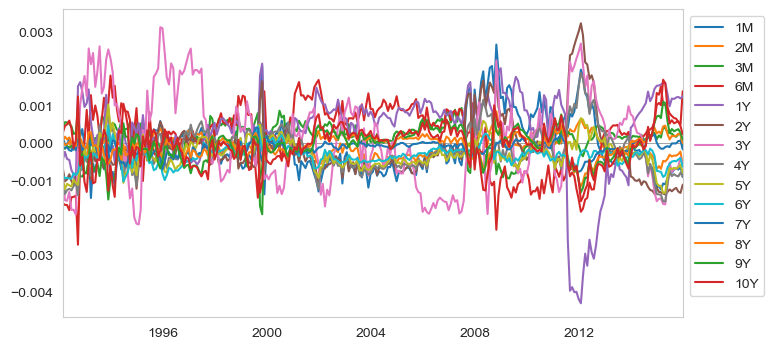

In [40]:
df_deep_recon = deepAE_model.predict(yield_curve)

plt.figure(figsize = (8, 4))
plt.plot(yield_curve.index, pd.DataFrame(df_deep_recon - yield_curve))
plt.xlim(yield_curve.index.min(), yield_curve.index.max())
plt.grid(False)
plt.legend(yield_curve.columns, loc = 'upper left', bbox_to_anchor = (1, 1))
plt.axhline(y = 0, c = "grey", linewidth = 0.5, zorder = 0)

#### Compare Reconstruction Models

reconstruction error는 원래 데이터 포인트와 부분 공간 사이의 직교 거리이다. 추가적인 튜닝이 필요하지만 Deep AE는 선형 AE보다 훨씬 낮은 재구성 오차를 나타내며 PCA와 유사하다는 것을 알 수 있다

In [41]:
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - yield_curve)**2, axis = 1))
ae_rec_errs = np.sqrt(np.sum((df_ae_recon - yield_curve) ** 2, axis = 1))
deep_rec_errs = np.sqrt(np.sum((df_deep_recon - yield_curve) ** 2, axis = 1))

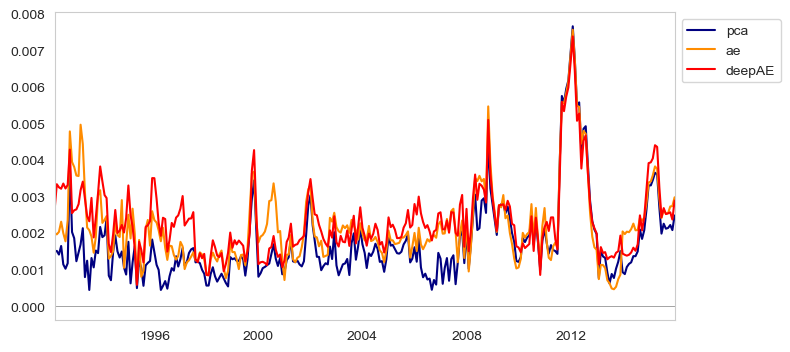

In [42]:
plt.figure(figsize = (8, 4))

plt.plot(yield_curve.index, pca_rec_errs, c = 'navy')
plt.plot(yield_curve.index, ae_rec_errs, c = 'darkorange')
plt.plot(yield_curve.index, deep_rec_errs, c = 'red')
plt.grid(False)

plt.xlim(yield_curve.index.min(), yield_curve.index.max())
plt.legend(['pca','ae','deepAE'], loc = 'upper left', bbox_to_anchor = (1, 1))
plt.axhline(y = 0, c = "grey", linewidth = 0.5, zorder = 0)